# Data Challenge : Introduction to Machine Learning (BGDIA703)

### Authors: 
#### Charlotte Laclau (charlotte.laclau@telecom-paris.fr)

This year's challenge is about text classification. 
For privacy reasons, you are only provided with the embedding learned on the original documents. 

### Fair document classification

The task is straightforward: assign the correct category to a text. This is thus a multi-class classification task with 28 classes to choose from.

The most adopted paradigm consists in training a network $f: \mathcal{X} \rightarrow \mathbb{R}^d$ which, from a given document $x \in \mathcal{X}$, extracts a feature vector $z \in \mathbb{R}^d$ which synthetizes the relevant caracteristics of $doc$. The diagnostic phase then consists, from an document $x$, to predict the label of the document based on the extracted features $z$. In this data challenge $d=768$. 

We directly provide you the embedding of each text (learned with BERT). 

The goal of this competition is to design a solution that is both accurate for predicting the label as well as fair with respect to some sensitive attribute (e.g. gender). Fairness in this context means that the model should not be biased toward a certain minority group present in the data. We explain this paradigm further in the evaluation part. 

### Downloading the Data: 

You can download the Dataset and evaluator script from the below links: 
**https://partage.imt.fr/index.php/s/3M3Mn3sN3TNSDEp**

**https://partage.imt.fr/index.php/s/CfajSjkAiq2oCLF**

After unzipping the file, you have one pickle file named ``data-challenge-student.pickle``.
In this file you have one dictionnary that contains the training set `X_train`, the test set `X_test`, the training label `Y_train`, and the information about the sensitive attribute in `S_train` and `S_test`.


In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
with open('data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)

In [2]:
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

In [3]:
print(X.shape, Y.shape, S.shape)
print(set(Y))

(27749, 768) (27749,) (27749,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


### Evaluation

First of all, the accuracy of the solutions are evaluated according to the Macro F1 metric, The Macro F1 score is simply the arithmetic average of the F1 score for each class.

We will also analyse proposed solutions according to their fairness with respect to the provided sensitive attribute ($S$). In other words, we want you to design a solution that is not biased towards one group in particular. To be specific, we will use (1-equal opportunity gap) between protected groups. A fair model is a model where this criteria is close to 1. 

Overall, your model should satisfy both criteria so the evaluation metric is the average between the macro F1 and the fairness criteria.

The file `evaluator.py` contains the required functions to compute the final score on which you will be ranked. 

### Baseline 

Let us use a logistic regression as our naive baseline model. Note that this model does not take into accout the sensitive attribute $S$. It will only be used for the evaluation.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from evaluator import *

In [5]:
# Train the logistic regression
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)
clf = LogisticRegression(random_state=0, max_iter=5000).fit(X_train, Y_train)

In [6]:
Y_pred = clf.predict(X_test)
eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])

In [7]:
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
print(final_score)
print(eval_scores['macro_fscore'], 1-eval_scores['TPR_GAP'])

0.7370551847185396
0.6684094498133081 0.805700919623771


As a first sight, we could see that this simple model perform quite well and score is marred by F1_score. Effectively, we could see that score relative to TPR_GAP is quite higher than F1_score, that increase overall performance.

In the following, we'll describe the process taht led to the solution and decompose it into 3 steps :
- Part I - Problem analysis, where objective will be to analyse the dataset in question,
- Part II - Baseline investiguation, here we'll have a close look on the initial solution and see if we can get some insight on how to improve performances,
- Part III - Solution, where we'll discose the solution and rational behind each steps considered.

### Part I - Problem analysis
First, we can explore labels distribution as well as sensitive groups counts for each label.

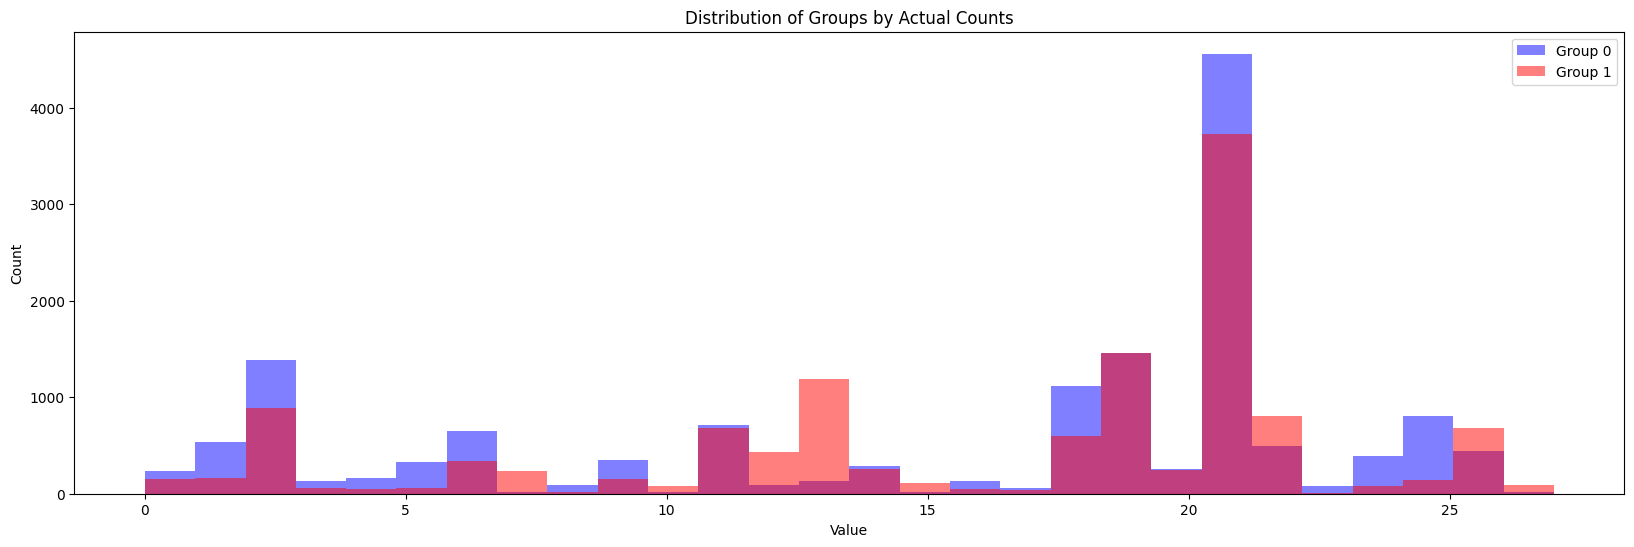

In [8]:
group_0 = Y[S == 0]
group_1 = Y[S == 1]

plt.figure(figsize=(20, 6))
plt.hist(group_0, bins=28, alpha=0.5, label='Group 0', color='blue')
plt.hist(group_1, bins=28, alpha=0.5, label='Group 1', color='red')

plt.title('Distribution of Groups by Actual Counts')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()

In [5]:
unique_values_group_0, counts_group_0 = np.unique(group_0, return_counts=True)
unique_values_group_1, counts_group_1 = np.unique(group_1, return_counts=True)

df_unique_counts_group_0 = pd.DataFrame({
    'Group 0': counts_group_0,
    'Group 1': counts_group_1
})

print(df_unique_counts_group_0[0:14].T)
print(df_unique_counts_group_0[15:].T)

          0    1     2    3    4    5    6    7   8    9   10   11   12    13
Group 0  237  540  1382  128  160  324  652   22  92  347  14  717   93   127
Group 1  150  163   891   56   46   62  342  240  15  152  79  685  431  1189
          15   16  17    18    19   20    21   22  23   24   25   26  27
Group 0   21  132  55  1113  1462  258  4559  494  83  391  805  441  21
Group 1  115   46  42   602  1456  246  3726  801   9   76  143  680  94


We can see that number of counts for each label is very variable, that can go from less than 100 counts and up to 8000 counts. Indeed, one label is over-representated compared to others whereas some labels (for example 3, 4, 8, 10, 15, 16, 17 ect...) have very low counts in comparison. 

In respect to sensitive groups, we could also see great variation within groups, with label 19 that is close to uniform and label 23 that have almost a factor of 10.

As we've seen when running the baseline, it would be essential to consider label / sensitive groups variability to get a proper f1_score and TPR_GAP compromise.

Now let have a look on the feature space by applying PCA :

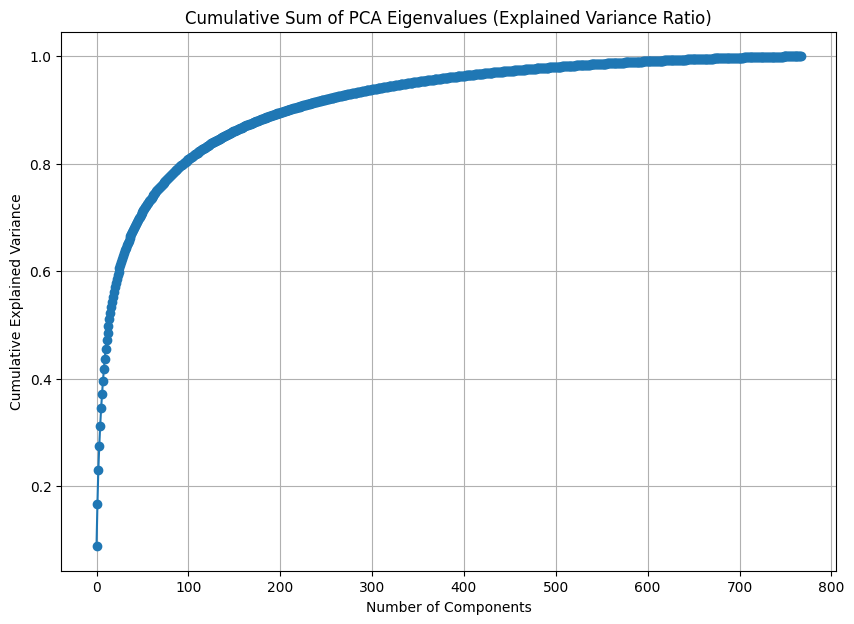

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


X_std = StandardScaler().fit_transform(X)

# PCA to compute eigenvalues and eigenvectors
pca = PCA()
X_pca = pca.fit(X_std)

# Eigenvalues (variance explained by each component)
eigenvalues = X_pca.explained_variance_

# Calculate the cumulative sum of eigenvalues
cumulative_sum_eigenvalues = np.cumsum(eigenvalues)

# Plot cumulative sum of eigenvalues (ratio of variance explained)
plt.figure(figsize=(10, 7))
plt.plot(cumulative_sum_eigenvalues /
         cumulative_sum_eigenvalues[-1], marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Sum of PCA Eigenvalues (Explained Variance Ratio)')
plt.grid(True)
plt.show()

80% of the variability within feature space is captured by the first 100 components and close to 90% with the 200 first components.

Let's try to visualize it using TSNE :

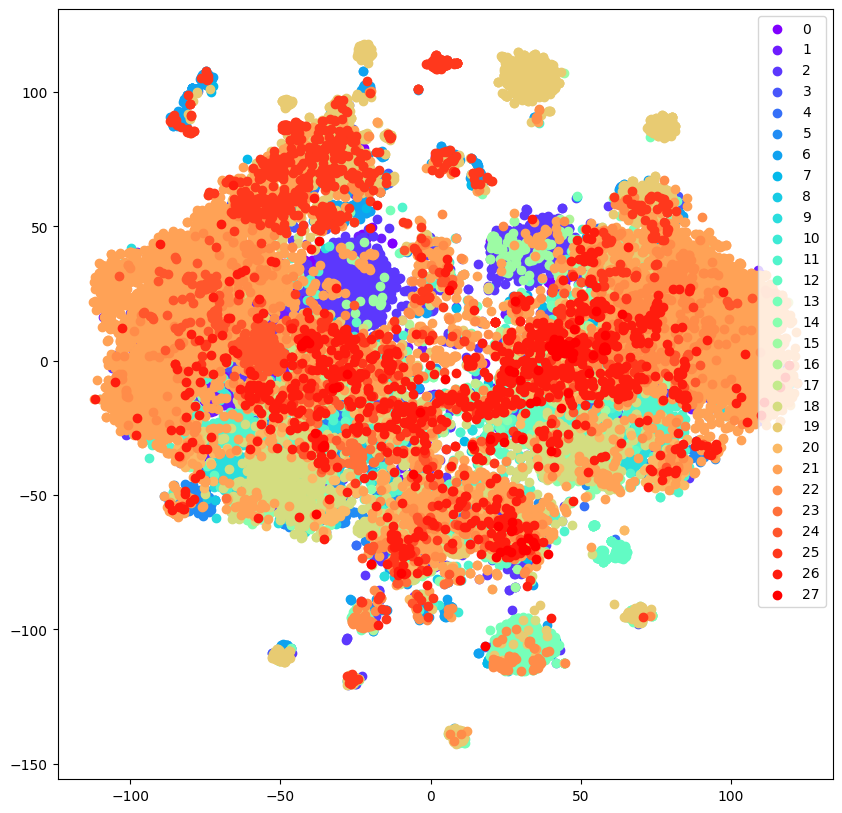

In [11]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Assuming `X` is your embeddings matrix and `Y` is an array of labels


def visualize_tsne(X, Y):
    # Join embeddings (X) and label (Y) information in a DataFrame
    tsne_data = pd.DataFrame(X)
    tsne_data['label'] = Y

    # t-SNE model
    tsne_model = TSNE(perplexity=40, n_components=2,
                      init='pca', n_iter=2500, random_state=23)
    tsne_vectors = tsne_model.fit_transform(tsne_data.iloc[:, :-1])

    # Visualize
    x = tsne_vectors[:, 0]
    y = tsne_vectors[:, 1]
    labels = tsne_data.iloc[:, -1]
    unique_labels = np.unique(Y)
    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    # Create a color map for the labels
    color_map = {label: color for label, color in zip(unique_labels, colors)}

    plt.figure(figsize=(10, 10))
    for label in unique_labels:
        indices = tsne_data['label'] == label
        plt.scatter(x[indices], y[indices], c=[color_map[label]], label=label)
    plt.legend()
    plt.show()


# Call the function with your data
visualize_tsne(X, Y)

We can confirm that there is no pattern that can be visualily discern in 2D. In the remaining, we'll continue to work in higher dimension space.

### Part II - Baseline investiguation

As describe in the problem statement :
- the macro f1_score is the arithmetic average of the f1 score for each class. The F1 score is a harmonic mean of precision (ratio of true positive predictions to all positive predictions) and recall (ratio of true positive predictions to all actual positives), providing a balance between the two.
- Fairness that is based on TPR_gap and is a measure of equal-opportunity gap. It targets to get similar True Positives Rates between the majority and minority groups for the sensitive groups.

Then this is clear that investiguating both score for each label class would be important to investiguate where performance coudl be improved.
To do so, we'll create a function that plot f1_score and Fairness score for each label :


In [18]:
def CheckSol(Y_pred, Y_true, S_true):

    # Call the gap_eval_scores function to obtain the evaluation scores and confusion matrices
    eval_scores, confusion_matrices = gap_eval_scores(Y_pred, Y_true, S_true)
    
    overall_scores = confusion_matrix_based_scores(confusion_matrices['overall'])
    # overall_scores['TPR'] contain the TPR for each class

    distinct_groups = [i for i in range(len(set(S_test)))]
    group_scores = {}
    for gid in distinct_groups:
        group_scores[gid] = confusion_matrix_based_scores(confusion_matrices[gid])
        # group_scores[gid]['TPR'] contain the TPR for each class for this specific group

    #####################################################
    # Calculate F1-score for each class for the overall data
        
    overall_precision = overall_scores['PPV']  # Precision for each class
    overall_recall = overall_scores['TPR']  # Recall for each class
    overall_f1_scores = 2 * (overall_precision * overall_recall) / \
        (overall_precision + overall_recall)

    # Calculate F1-scores for each class for each sensitive group
    group_f1_scores = {}
    for gid in distinct_groups:
        group_scores_F1 = confusion_matrix_based_scores(confusion_matrices[gid])
        group_precision = group_scores_F1['PPV']
        group_recall = group_scores_F1['TPR'] 

        group_f1_scores[gid] = 2 * (group_precision *
                                    group_recall) / (group_precision + group_recall)

    #####################################################
    # Plotting

    n_classes = len(overall_scores['TPR'])
    classes = range(n_classes)
    group_0 = Y_true[S_true == 0]
    group_1 = Y_true[S_true == 1]

    plt.figure(figsize=(20,20))
    plt.subplot(4,2,1)
    plt.hist(group_0, bins=28, alpha=0.5,
            label='Group 0', color='blue', density=True)
    plt.hist(group_1, bins=28, alpha=0.5,
            label='Group 1', color='red', density=True)

    plt.title('Distribution of Groups by Ratios')
    plt.xlabel('Value')
    plt.ylabel('Ratio')
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.bar(classes, overall_scores['TPR'], color='green')
    plt.title('TPR by Class - Overall')
    plt.xlabel('Class')
    plt.ylabel('TPR')

    plt.subplot(4, 2, 4)
    plt.bar(classes, overall_f1_scores, color='green')
    plt.title('F1_Score by Class - Overall')
    plt.xlabel('Class')
    plt.ylabel('F1_Score')

    plt.subplot(4, 2, 5)
    plt.bar(classes, group_scores[0]['TPR'], color='orange')
    plt.title('TPR by Class - Sensitive Group 0')
    plt.xlabel('Class')
    plt.ylabel('TPR')

    plt.subplot(4, 2, 6)
    plt.bar(classes, group_f1_scores[0], color='orange')
    plt.title('F1_Score by Class - Sensitive Group 0')
    plt.xlabel('Class')
    plt.ylabel('F1_Score')

    plt.subplot(4, 2, 7)
    plt.bar(classes, group_scores[1]['TPR'], color='purple')
    plt.title('TPR by class for sensitive group 1')

    plt.subplot(4, 2, 8)
    plt.bar(classes, group_f1_scores[1], color='purple')
    plt.title('F1_Score by Class - Sensitive Group 1')
    plt.xlabel('Class')
    plt.ylabel('F1_Score')

    plt.show()

We can check for the test dataset of the baseline :

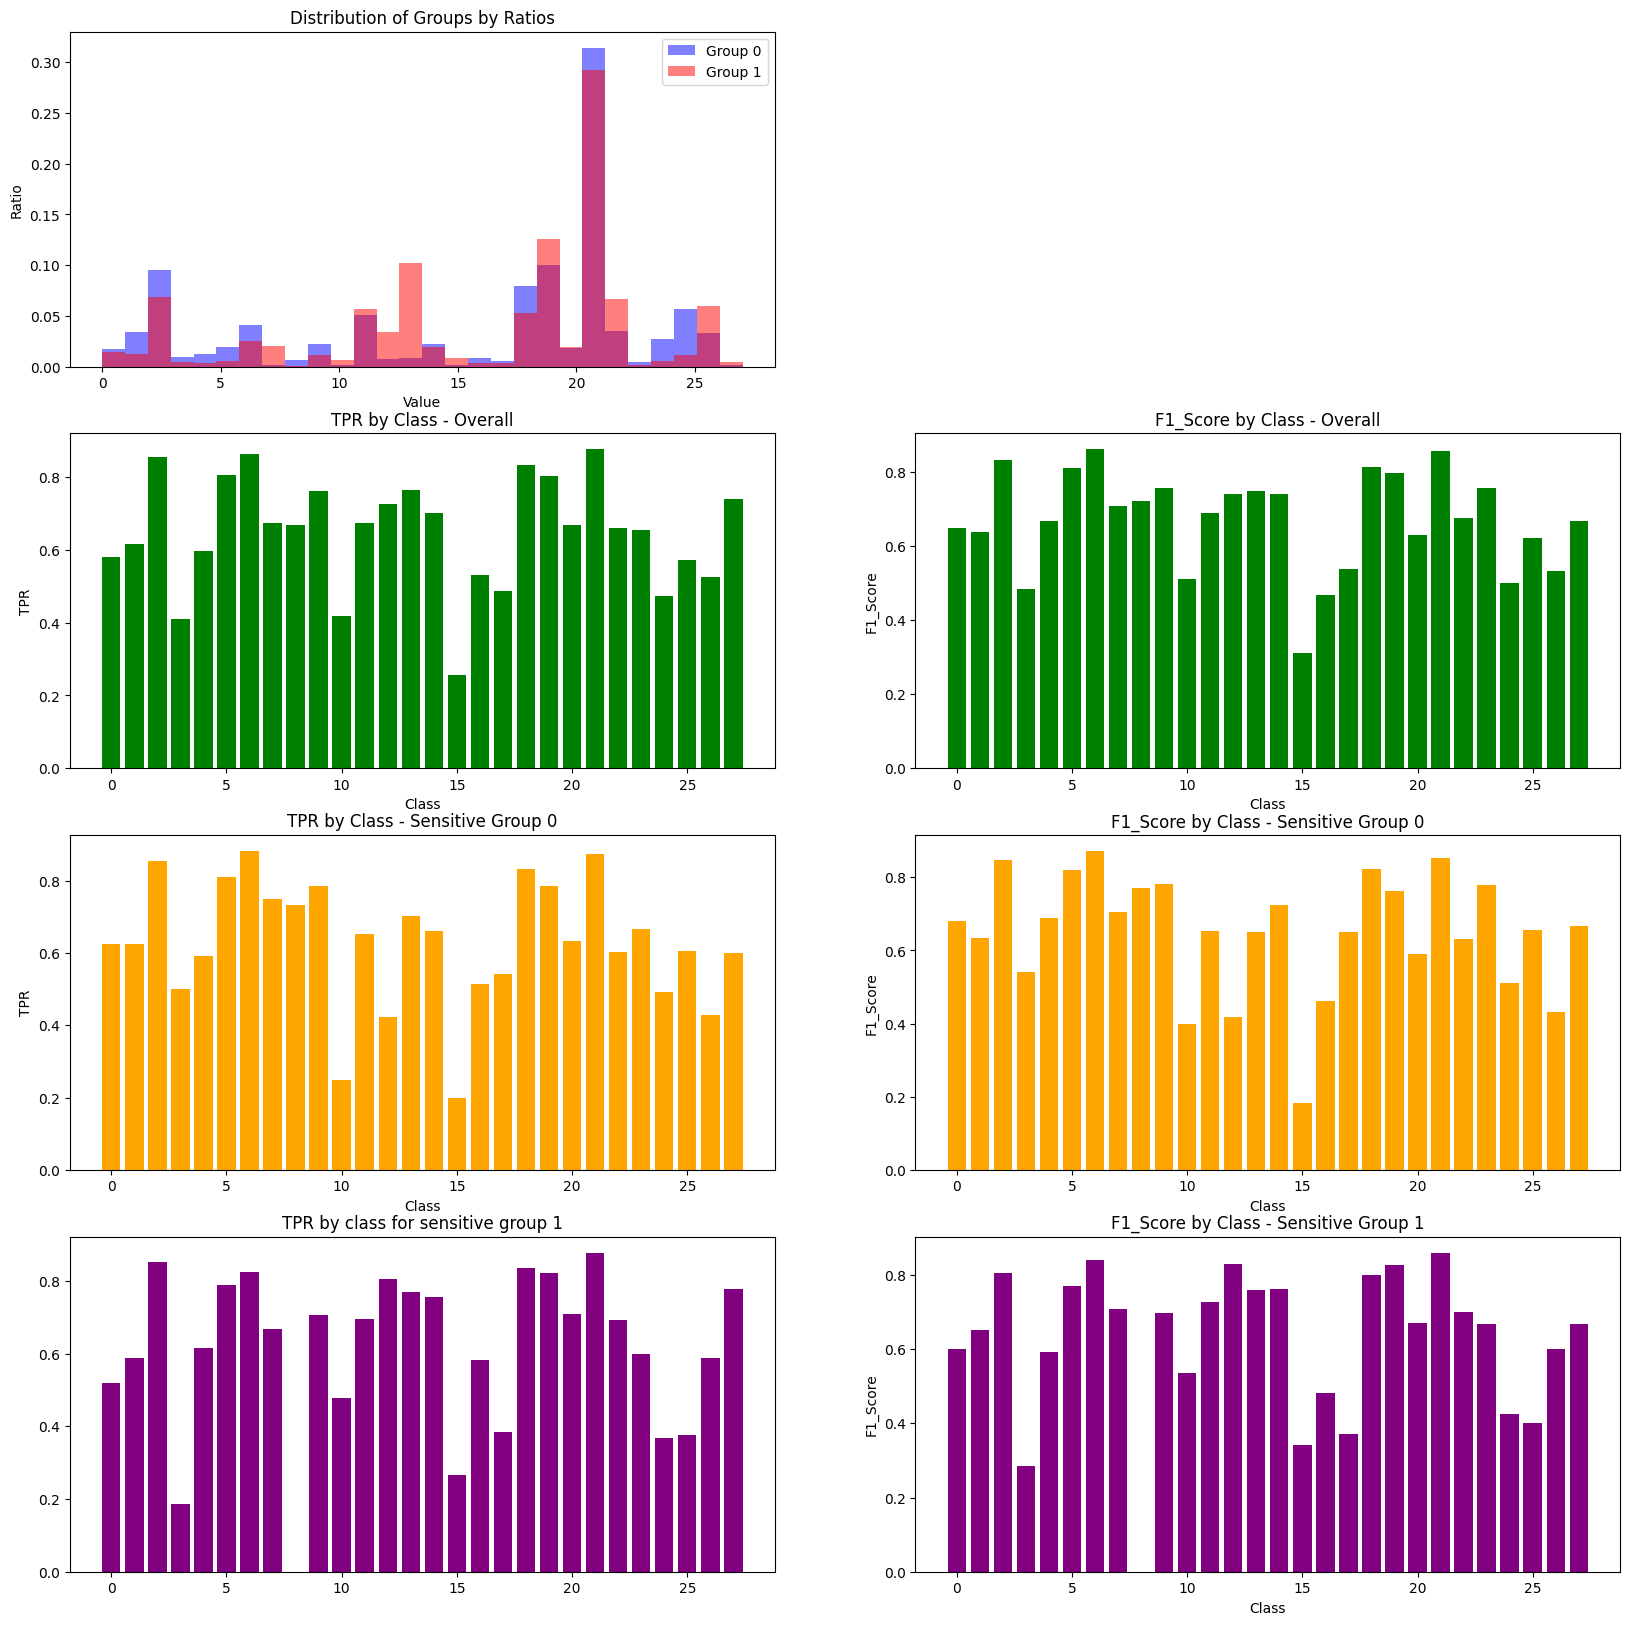

In [19]:
CheckSol(Y_pred, Y_test, S_test)

We can first highlight the fact that the model performance for most of the class are quite OK but are clearly impacted by few class that are lowering performance (both TPR_GAP and f1_score).
Note that performance are very poor for class {3, 10, 15, 16, 24}. By checking their counts, we can see that all three have very few counts and very umbalanced in term of sensitive groups.

This is also essential to check model performance on the train dataset :

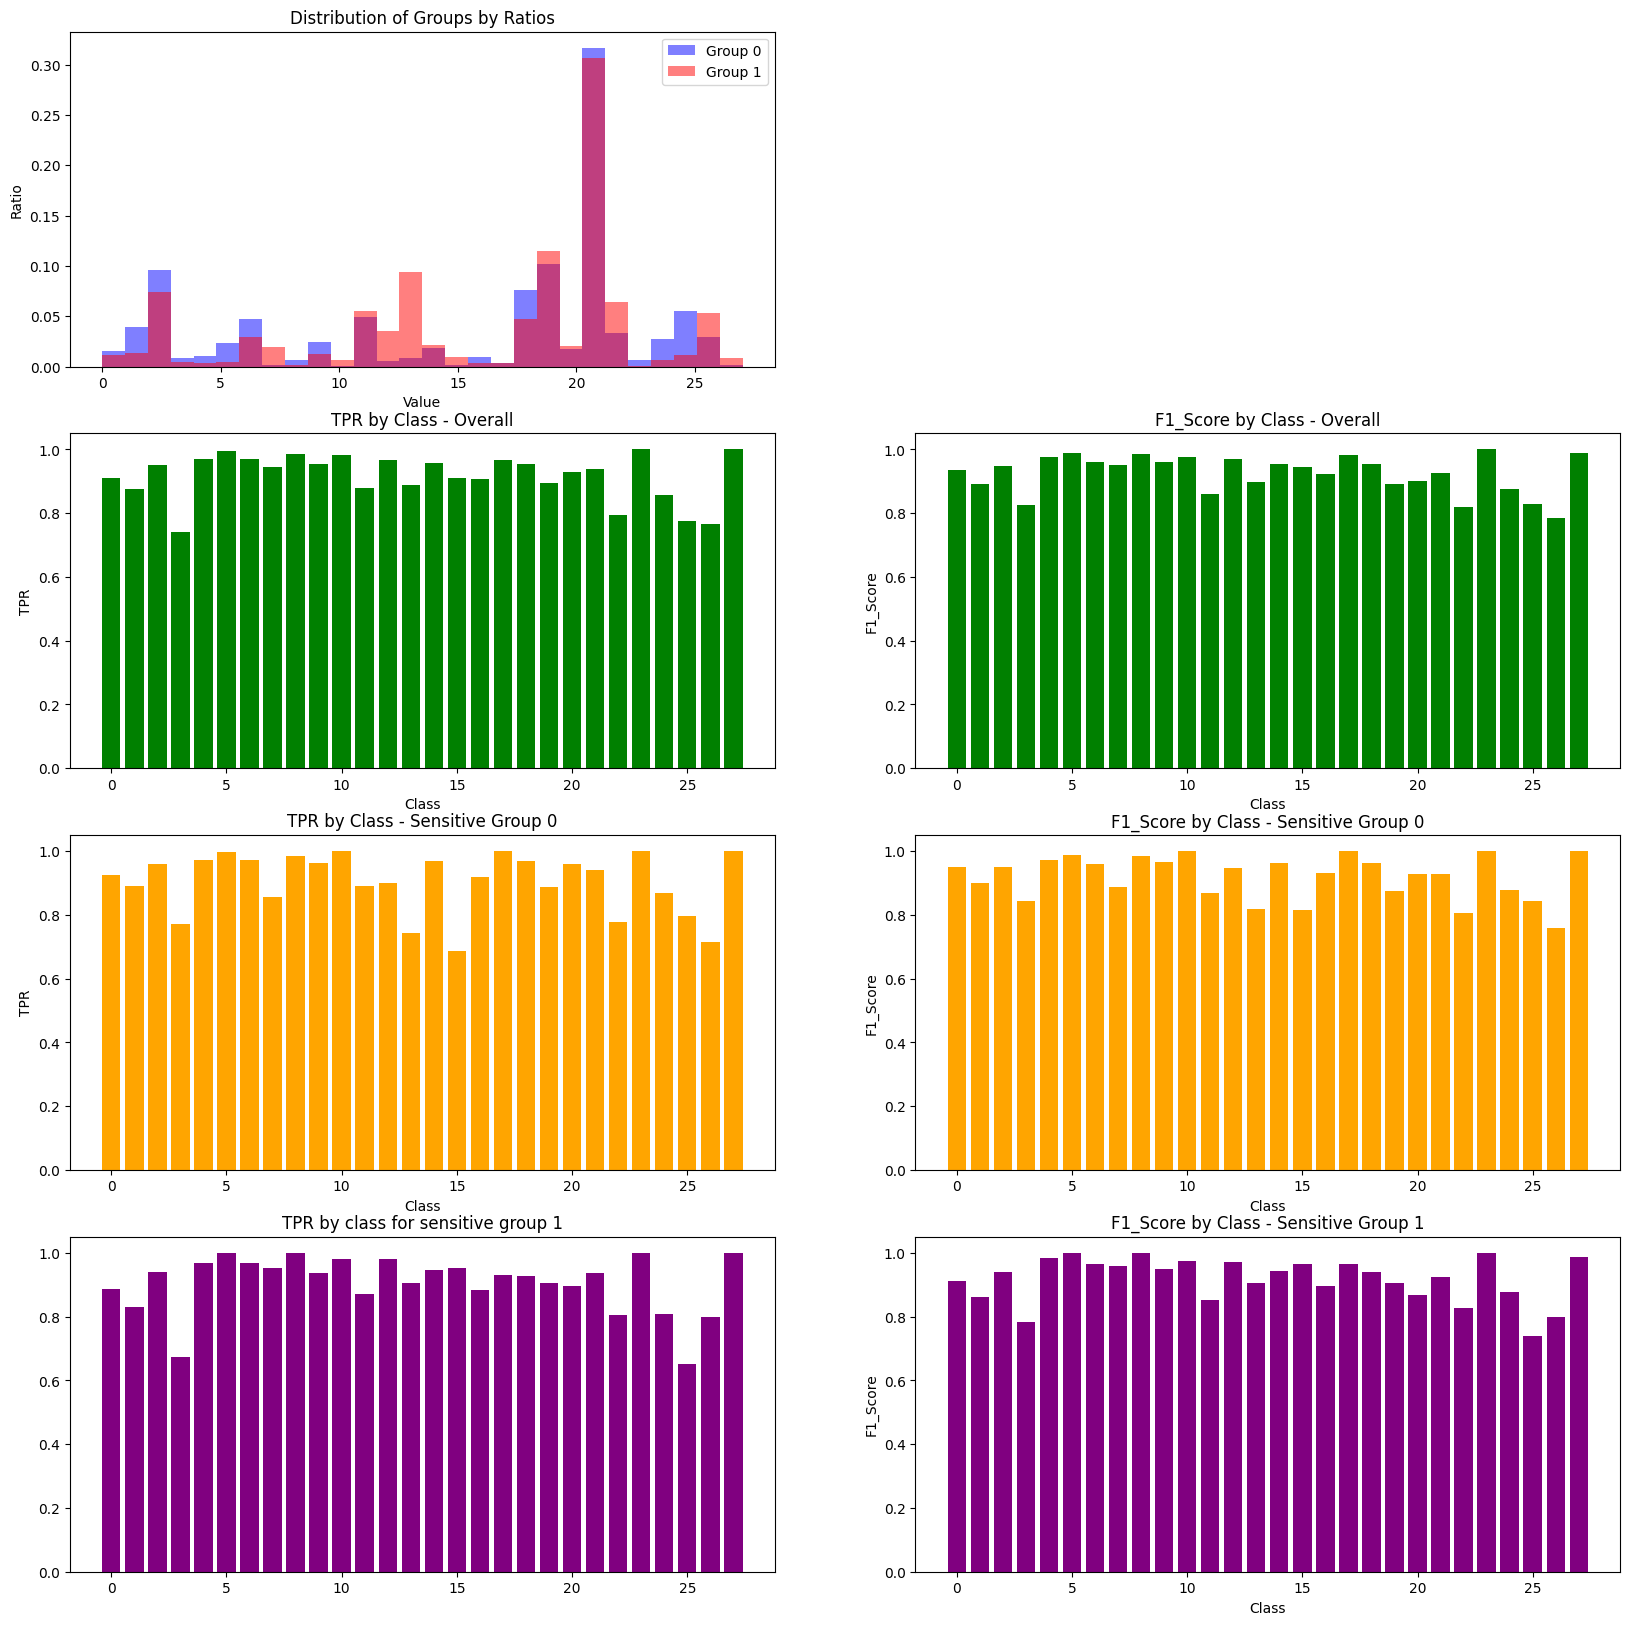

In [20]:
Y_pred_train = clf.predict(X_train)
CheckSol(Y_pred_train, Y_train, S_train)

In [16]:
eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred_train, Y_train, S_train, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
print(final_score)
print(eval_scores['macro_fscore'], 1-eval_scores['TPR_GAP'])


0.9231052551376074
0.9250086796915079 0.921201830583707


On the contrary, we could see that on the train dataset the performance are really good, which is a typical mark of overfitting.

As we already discussed, both label and sensitive groups distribution are variable. Current splitting (train_test_split) does not guarante that same ratio would be applicable for train and test dataset, and it highly possible that this is even worse on the final test set (during submission).

Then to recap, we can summarize some constraints that we have discover :
- Classifier would need to be robust to over-fitting,
- Classifier would need to be robust to class and sensitive ratio change,
- As f1_score is based on mean statistic, we would need to prevent some class to perform very poorly (same for TPR)

### Part II - Solution

While litteracy would provide amounts of different frameworks and different architecture, with limited time the strategy is then to start from simple concept and optimize using insight from experiences.
Effectively, this problem has inter-dependencies :
- increasing f1_score could impact negatively TPR_gap,
- increase overall score on one label could impact negatively another / rest of labels.

Then idea would be to do steps as simple (to control as much as possible side-effects) and as indepdendent as possible.

**Initial idea :** ''one-vs-rest' would allow to get one classifier specific to each label. This classifier would be confronted to all other classifier.
This goes into having independent step as 1 classifier would be used per label, and the intuition is that it would also help to increase robustness in case of label ratio change.

Trying to compare local score and online score, we can effectively see that even if 'ovr' get lower local scores, we have more stable result with such method. 

**Addressing sensitive groups :** this does not address the variabitility on sensitive group ratio. As the target is to get 1-equal opportunity, we want to prevent any model bias toward any class.
One idea to cover both constraint is then to equalize sensitive groups counts for each label class. 

To do so, we'll use SMOTE technique that is an over-sampling method. Imblearn provide specific function but need to define a strategy. As our target is, for a specifc label class, to align sensitive groups counts then we could apply SMOTE for each class label.

**Over-fitting :** 
to prevent over-fitting, we could use combination of :
- tune number of PCA components used,
- used regularization during the model training,

Appropriate tuning would be discern is the training score is relatively close to test score. If the gap between the two is too large (as for baseline), then it is very we cannot guarantee any result on the final test dataset (during submission).

**Model choice :** I investiguate Multi-layer Perceptron with expectation to capture non-linear patterns that could be captured by Logistic regression. However I encounter 2 issues :
- MLP is more prone to overfitting, then choise of adequate number of hidden layers and hidden layers size are tricky,
- MLP is less robust from one run to another (initialization, batch choice ect...)

With such issues, having good results locally could not guarantee such performance during submission.
I tried to use one-vs-rest method with MLP to try to get more stable result without success. Then I decided to stay with linear regression that get submission score aligned to local scores. With such choice, the regularization will be using l2 norm.

In [23]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train_2, X_test_2, Y_train_2, Y_test_2, S_train_2, S_test_2 = train_test_split(
    X, Y, S, test_size=0.3, random_state=42, stratify=Y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled = scaler.transform(X_test_2)

####  PCA to reduce dimensions
pca = PCA(n_components=750)
X_train_pca = pca.fit_transform(X_train_scaled) 
X_test_pca = pca.transform(X_test_scaled)

Cls_to_SMOTE = []

unique_classes = np.unique(Y)

X_train_oversampled = []
Y_train_oversampled = []
S_train_oversampled = []

for cls in unique_classes:
    class_mask = Y_train_2 == cls
    X_class, Y_class, S_class = X_train_pca[class_mask], Y_train_2[class_mask], S_train_2[class_mask]
    
    # Apply standard SMOTE for non-Cls_to_SMOTE classes
    if cls not in Cls_to_SMOTE:
        smote = SMOTE(random_state=42)
        X_class_smote, S_class_smote = smote.fit_resample(X_class, S_class)
    else:
        # Define custom SMOTE application for Cls_to_SMOTE
        counts = Counter(S_class)
        majority_group = max(counts, key=counts.get)
        minority_group = min(counts, key=counts.get)

        target = int(2.5* max(counts.values()))
        
        # Define the SMOTE strategy
        strategy = {
            majority_group: target,
            minority_group: target
        }
        
        smote = SMOTE(sampling_strategy=strategy, random_state=42)
        X_class_smote, S_class_smote = smote.fit_resample(X_class, S_class)
    
    # Store oversampled data
    X_train_oversampled.append(X_class_smote)
    Y_train_oversampled.extend([cls] * len(X_class_smote))
    S_train_oversampled.append(S_class_smote)

# Concatenate all oversampled data
X_train_smote = np.vstack(X_train_oversampled)
Y_train_smote = np.array(Y_train_oversampled)
S_train_smote = np.concatenate(S_train_oversampled)

# #### Train the model
model_smote_pca = LogisticRegression(random_state=0, max_iter=5000, C= 0.005, multi_class='ovr') 
model_smote_pca.fit(X_train_smote, Y_train_smote)
Y_pred_train = model_smote_pca.predict(X_train_smote)
eval_scores_train, confusion_matrices_eval_train = gap_eval_scores(
    Y_pred_train, Y_train_smote, S_train_smote, metrics=['TPR'])
final_score_train = (eval_scores_train['macro_fscore'] +
                     (1-eval_scores_train['TPR_GAP']))/2

# Predict on the test set
Y_pred_2 = model_smote_pca.predict(X_test_pca)
eval_scores_2, confusion_matrices_eval_2 = gap_eval_scores(
    Y_pred_2, Y_test_2, S_test_2, metrics=['TPR'])

final_score_2 = (eval_scores_2['macro_fscore'] +
                 (1-eval_scores_2['TPR_GAP']))/2

print(
    f"Train {final_score_train:.4f} / F1_score : {eval_scores_train['macro_fscore']:.4f}, TPR_GAP {1-eval_scores_train['TPR_GAP']:.4f}")
print(
    f"Test : {final_score_2:.4f} / F1_score : {eval_scores_2['macro_fscore']:.4f}, TPR_GAP {1-eval_scores_2['TPR_GAP']:.4f}")


Train 0.8266 / F1_score : 0.8193, TPR_GAP 0.8339
Test : 0.7820 / F1_score : 0.6824, TPR_GAP 0.8816


Performance have quite improved in both respect to f1_score and TPR_GAP.

NB: As said, we will monitor both train and test score. Then train_test_split is still required. But to prevent any unfortunate configuration, we want to ensure that all class would be represented sufficiently in the train dataset. Thus we are using 'stratify' option.

First, we could verify the impact of SMOTE and that sensitive groups are correctly aligned within each label class:

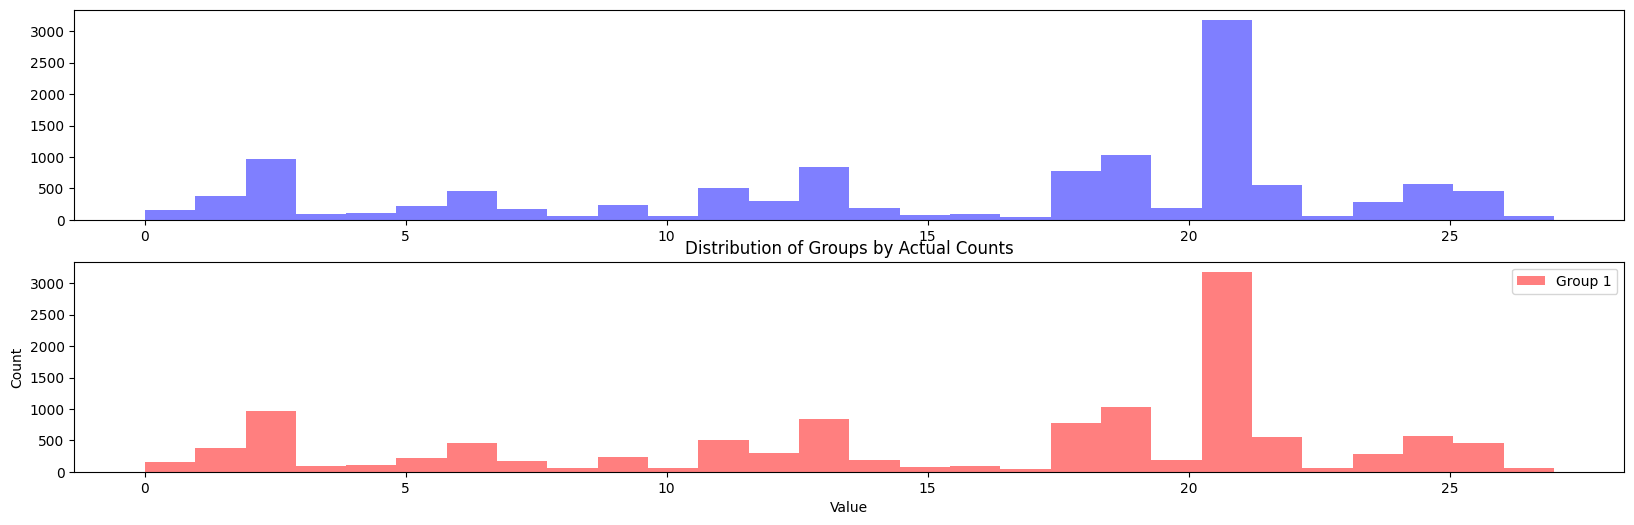

In [24]:
# Assume Y is the data and S is the array indicating the group (0 or 1)
group_0 = Y_train_smote[S_train_smote == 0]
group_1 = Y_train_smote[S_train_smote == 1]

plt.figure(figsize=(20, 6))
# Plot histograms for each group with different colors and some transparency
plt.subplot(2,1,1)
plt.hist(group_0, bins=28, alpha=0.5, label='Group 0', color='blue')
plt.subplot(2,1,2)
plt.hist(group_1, bins=28, alpha=0.5, label='Group 1', color='red')

plt.title('Distribution of Groups by Actual Counts')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()

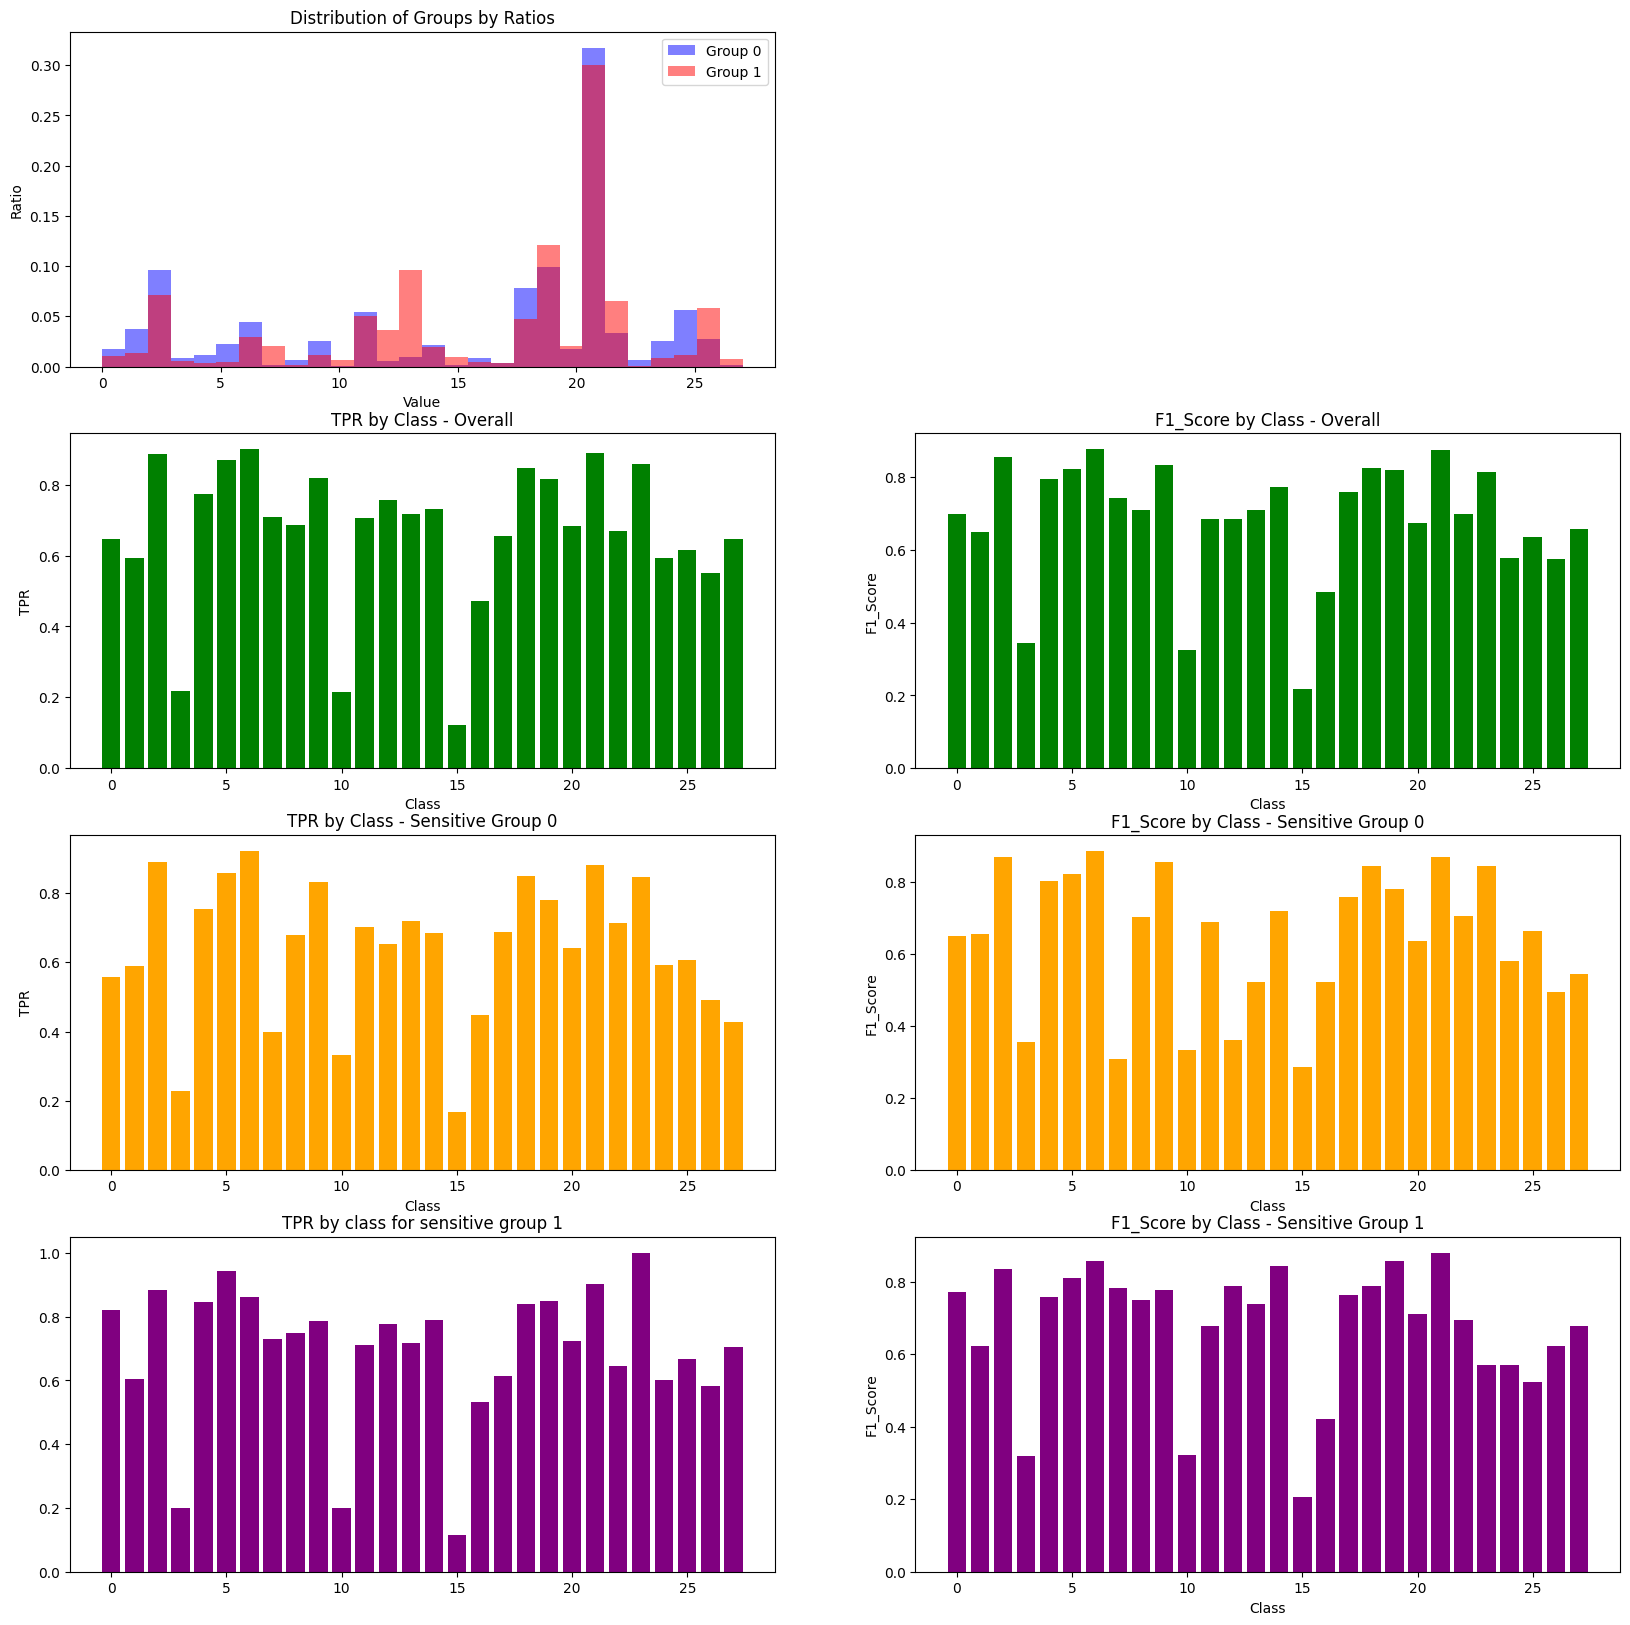

In [26]:
CheckSol(Y_pred_2, Y_test_2, S_test_2)

Unfortunatly, performance are very impact with few label classes : {3, 10, 15}.
To discern what is the cause, we'll start to investiguate train score :

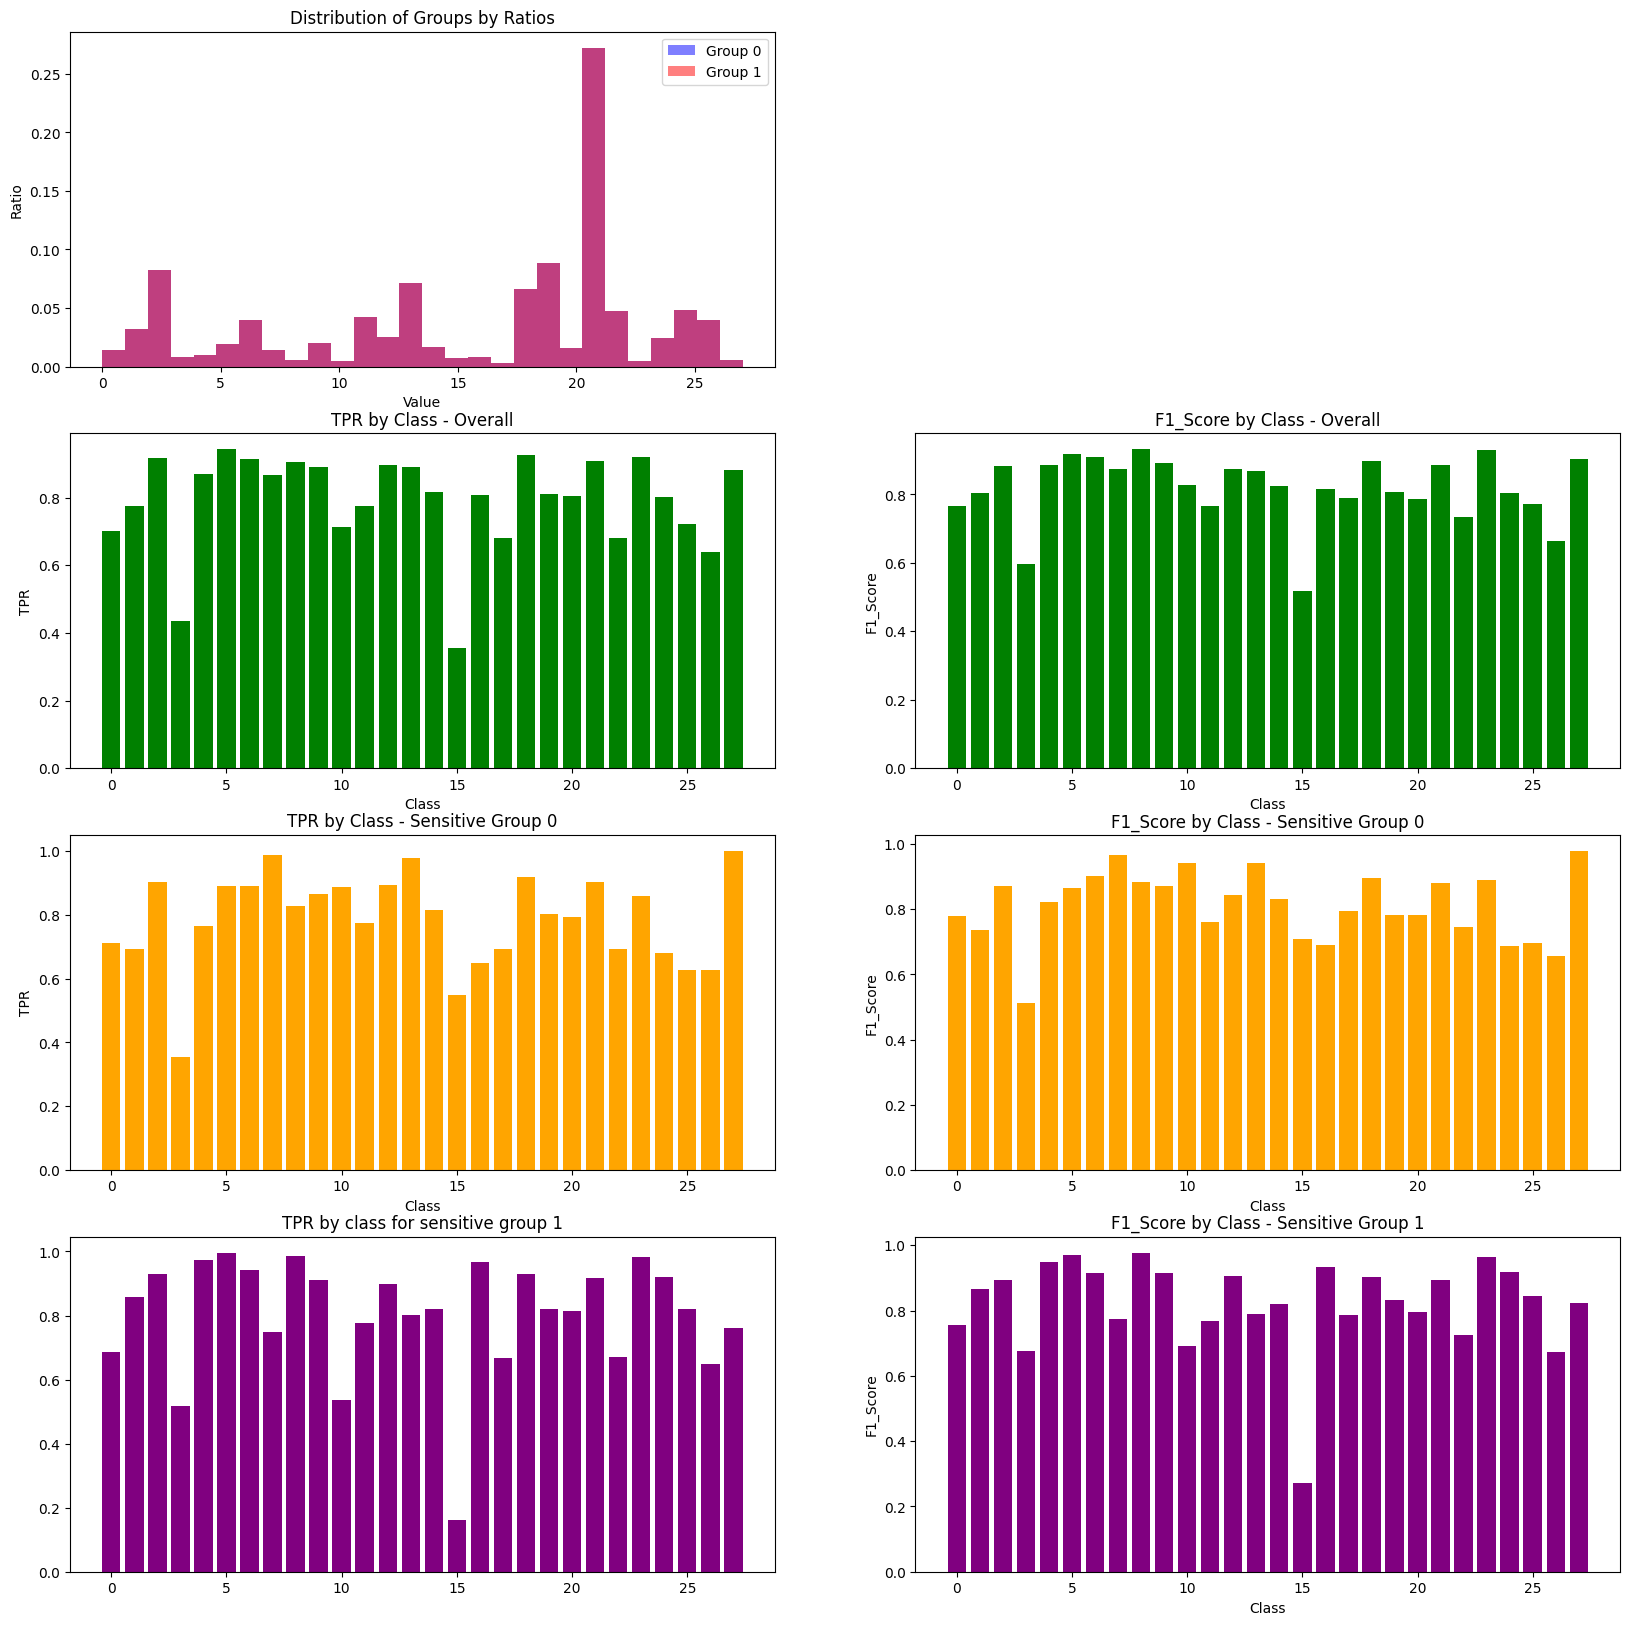

In [27]:
CheckSol(Y_pred_train, Y_train_smote, S_train_smote)

We can see that for class {3, 15} train performance are also poor. As the classifier are unable to learn during training, it explain why test performance are low.
Then final idea (implemented in code but bypass with Cls_to_SMOTE = []) is to get specific behavior for these two class.

As we have seen during the Part I, these two class have very few samples, respectively [(128, 56), (21, 115)]. Then final idea would be to over-sample more aggressively both class to ensure classifier have sufficient samples to learn.
Note that by doing so we are also more likely to overfit, then in parallel we'll increase regularization effect.

In [28]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train_2, X_test_2, Y_train_2, Y_test_2, S_train_2, S_test_2 = train_test_split(
    X, Y, S, test_size=0.3, random_state=42, stratify=Y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled = scaler.transform(X_test_2)

####  PCA to reduce dimensions
pca = PCA(n_components=750)
X_train_pca = pca.fit_transform(X_train_scaled) 
X_test_pca = pca.transform(X_test_scaled)

Cls_to_SMOTE = [3,15]

unique_classes = np.unique(Y)

X_train_oversampled = []
Y_train_oversampled = []
S_train_oversampled = []

for cls in unique_classes:
    class_mask = Y_train_2 == cls
    X_class, Y_class, S_class = X_train_pca[class_mask], Y_train_2[class_mask], S_train_2[class_mask]
    
    # Apply standard SMOTE for non-Cls_to_SMOTE classes
    if cls not in Cls_to_SMOTE:
        smote = SMOTE(random_state=42)
        X_class_smote, S_class_smote = smote.fit_resample(X_class, S_class)
    else:
        # Define custom SMOTE application for Cls_to_SMOTE
        counts = Counter(S_class)
        majority_group = max(counts, key=counts.get)
        minority_group = min(counts, key=counts.get)

        target = int(2.5* max(counts.values()))
        
        # Define the SMOTE strategy
        strategy = {
            majority_group: target,
            minority_group: target
        }
        
        smote = SMOTE(sampling_strategy=strategy, random_state=42)
        X_class_smote, S_class_smote = smote.fit_resample(X_class, S_class)
    
    # Store oversampled data
    X_train_oversampled.append(X_class_smote)
    Y_train_oversampled.extend([cls] * len(X_class_smote))
    S_train_oversampled.append(S_class_smote)

# Concatenate all oversampled data
X_train_smote = np.vstack(X_train_oversampled)
Y_train_smote = np.array(Y_train_oversampled)
S_train_smote = np.concatenate(S_train_oversampled)

# #### Train the model
model_smote_pca = LogisticRegression(random_state=0, max_iter=5000, C= 0.00335, multi_class='ovr') 
model_smote_pca.fit(X_train_smote, Y_train_smote)
Y_pred_train = model_smote_pca.predict(X_train_smote)
eval_scores_train, confusion_matrices_eval_train = gap_eval_scores(
    Y_pred_train, Y_train_smote, S_train_smote, metrics=['TPR'])
final_score_train = (eval_scores_train['macro_fscore'] +
                     (1-eval_scores_train['TPR_GAP']))/2

# Predict on the test set
Y_pred_2 = model_smote_pca.predict(X_test_pca)
eval_scores_2, confusion_matrices_eval_2 = gap_eval_scores(
    Y_pred_2, Y_test_2, S_test_2, metrics=['TPR'])

final_score_2 = (eval_scores_2['macro_fscore'] +
                 (1-eval_scores_2['TPR_GAP']))/2

print(
    f"Train {final_score_train:.4f} / F1_score : {eval_scores_train['macro_fscore']:.4f}, TPR_GAP {1-eval_scores_train['TPR_GAP']:.4f}")
print(
    f"Test : {final_score_2:.4f} / F1_score : {eval_scores_2['macro_fscore']:.4f}, TPR_GAP {1-eval_scores_2['TPR_GAP']:.4f}")


Train 0.8194 / F1_score : 0.8241, TPR_GAP 0.8147
Test : 0.7818 / F1_score : 0.6799, TPR_GAP 0.8836


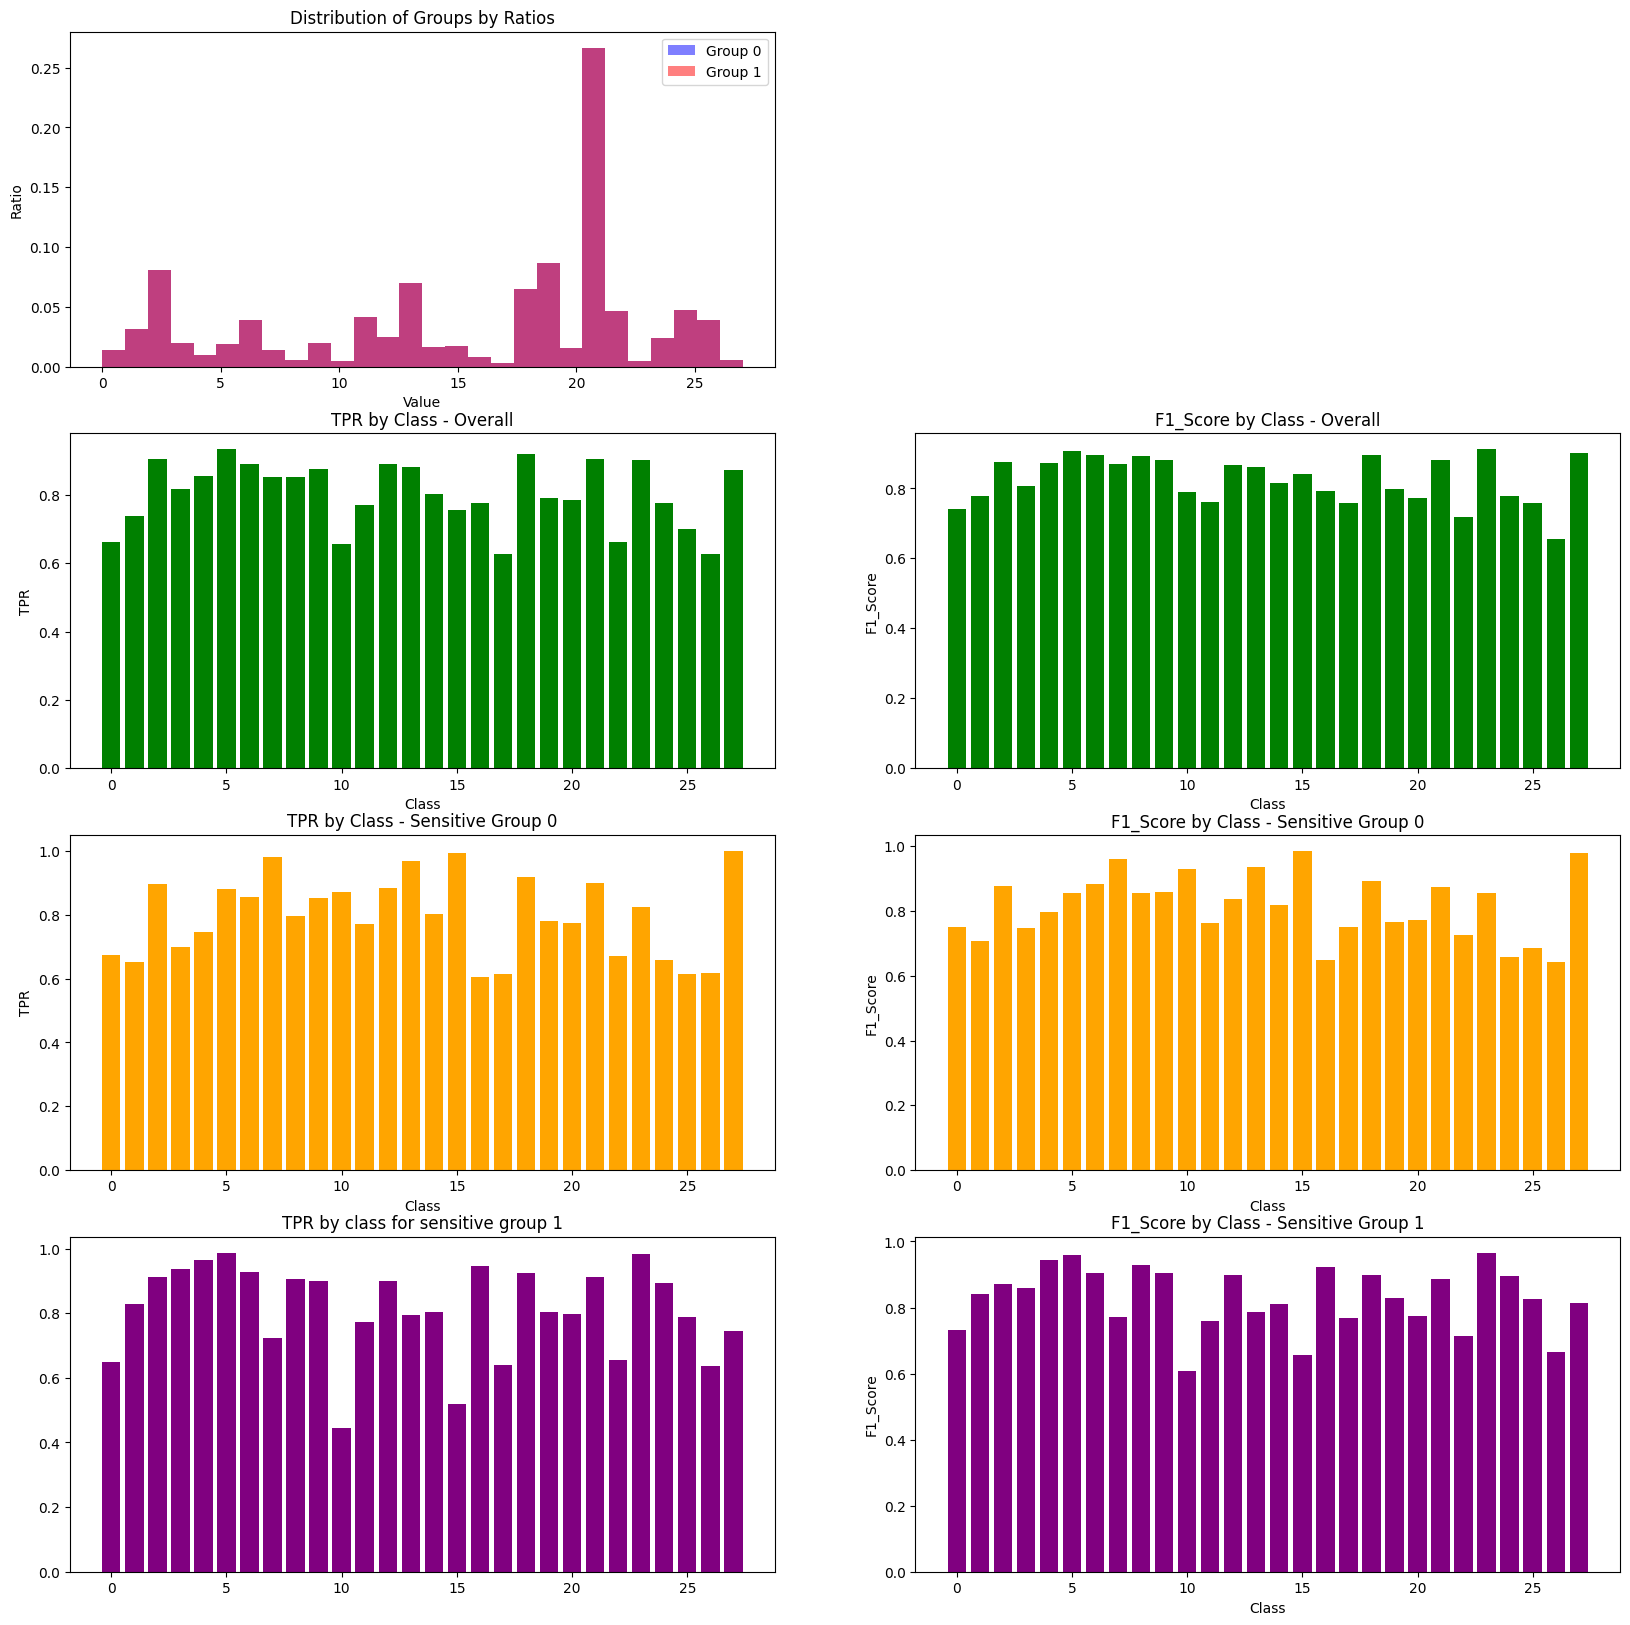

In [29]:
CheckSol(Y_pred_train, Y_train_smote, S_train_smote)

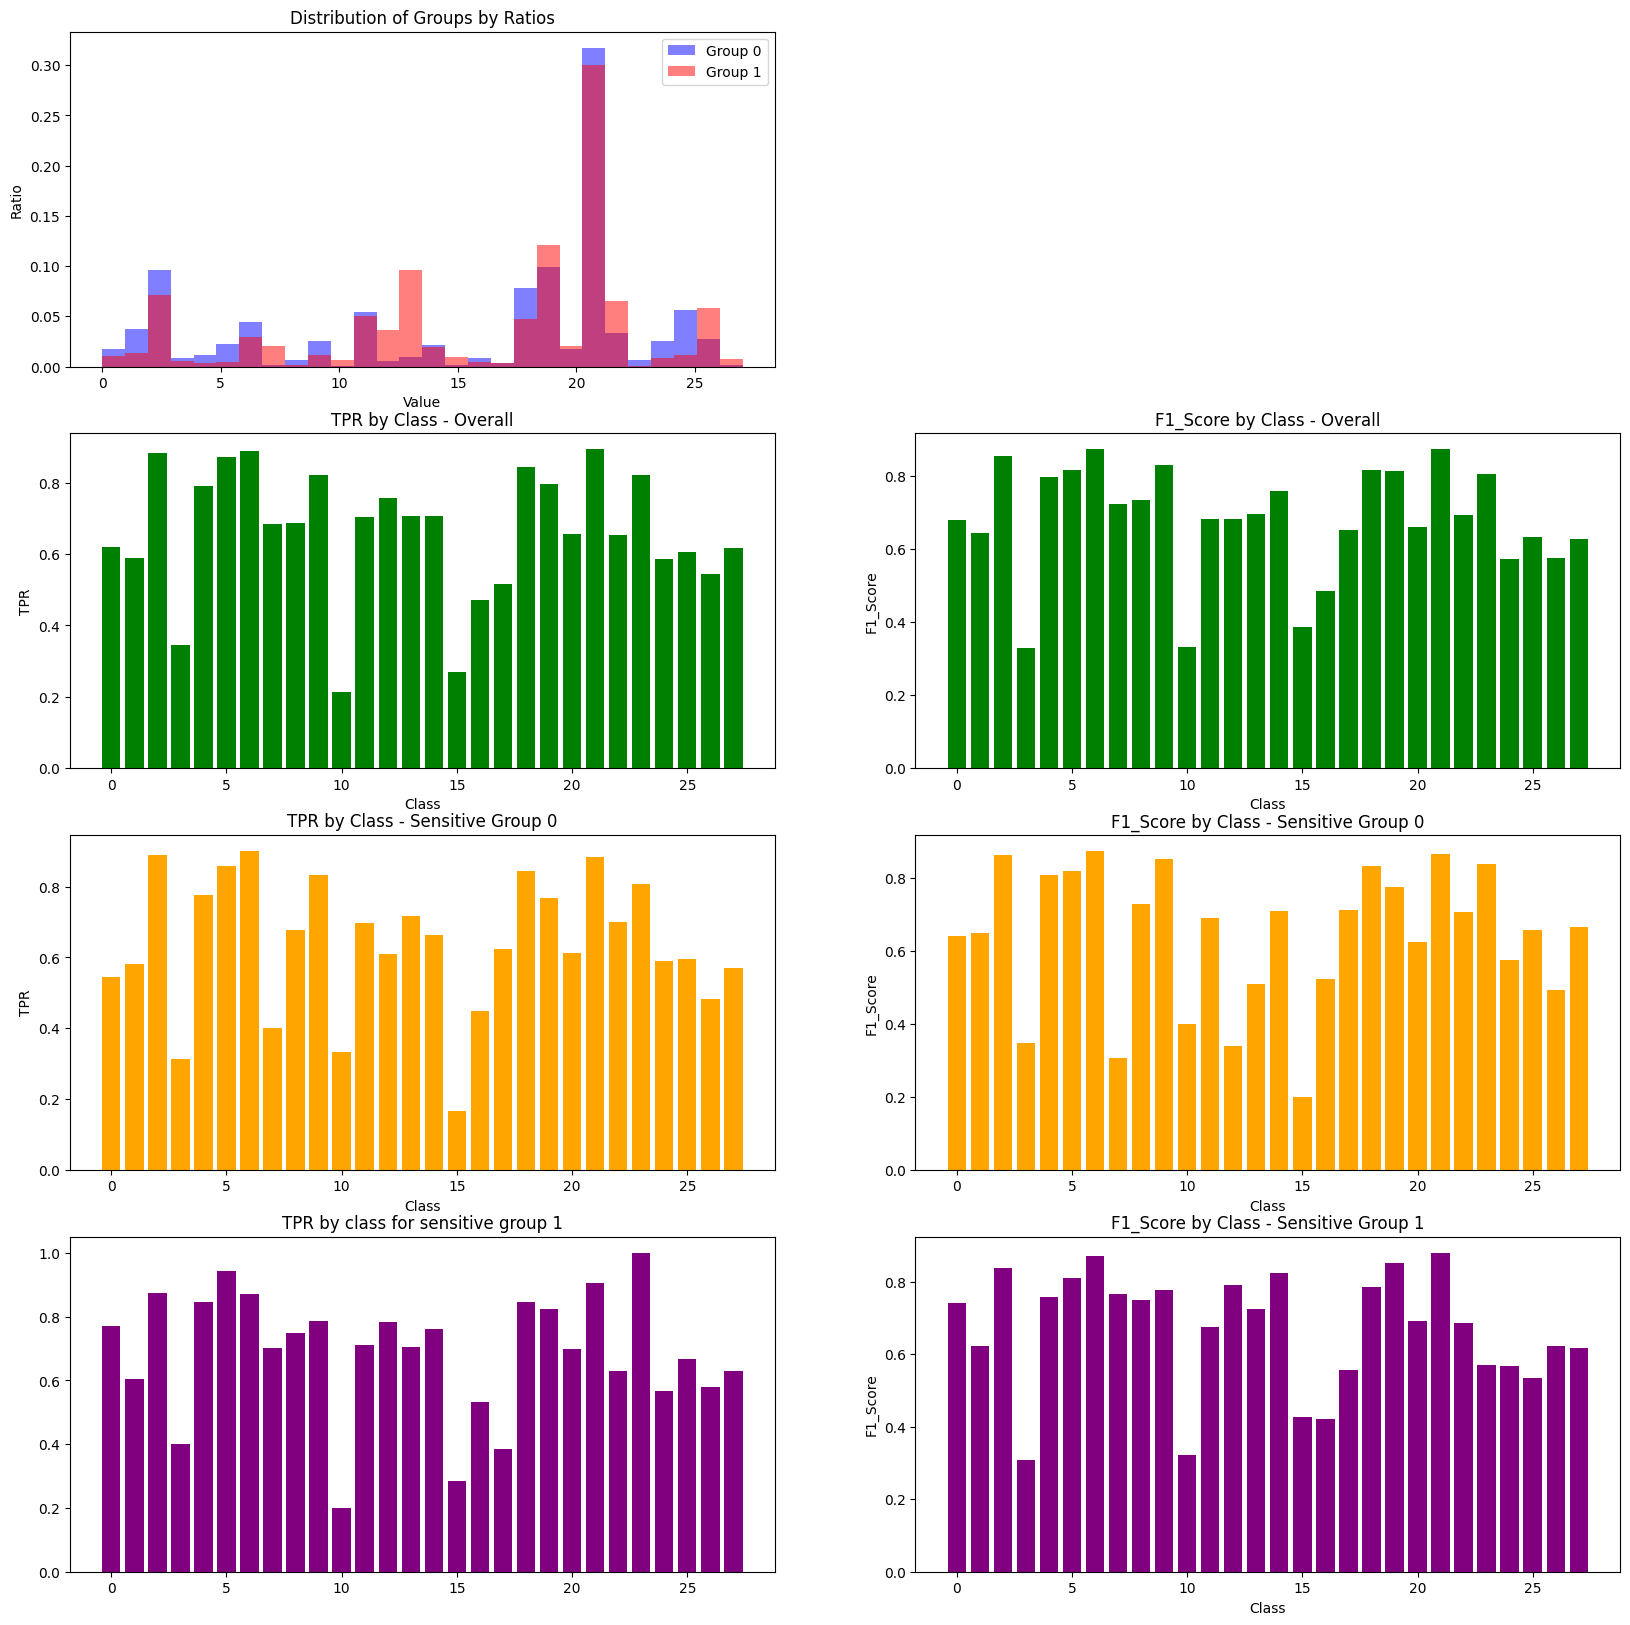

In [31]:
CheckSol(Y_pred_2, Y_test_2, S_test_2)

Here we can see that the classifier succeed to learn during the training. We can also see that the gap between train and test score decrease with equal test performance that is a good sign.

However, locally the performance doesn't seem to be improved in the local test dataset whereas there is score improvment during submission.
That's why regularization term have been finetune grossly with several submission.

Note also that final solution has specific over-sampling only for class {3,15}. Indeed adding 'virtual' sample will help for these specific class but are very likely to worsen for rest of the class (there is still dependence from one classifier to another). That's why target has been to add as less as specific over-sampling as possible.

Finally, note that to prevent that local train/test split decrease too much number of class counts, model training has been done on the global dataset (X, Y) - see below.

### Preparing the submission file

Now we are ready to prepare a submission file. In the pickle you have access to some additional test data (`X_test`, `S_test`) and you should submit your prediction for `Y`.
Note that with the current model, you do not need `S_test` but we provide it to you in case you want to use it in a debiasing strategy.

In [220]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

####  PCA to reduce dimensions
pca = PCA(n_components=760)
X_train_pca = pca.fit_transform(X_train_scaled) 

Cls_to_SMOTE = [3,15]

unique_classes = np.unique(Y)

X_train_oversampled = []
Y_train_oversampled = []
S_train_oversampled = []

for cls in unique_classes:
    class_mask = Y == cls
    X_class, Y_class, S_class = X_train_pca[class_mask], Y[class_mask], S[class_mask]
    
    # Apply standard SMOTE for non-Cls_to_SMOTE classes
    if cls not in Cls_to_SMOTE:
        smote = SMOTE(random_state=42)
        X_class_smote, S_class_smote = smote.fit_resample(X_class, S_class)
    else:
        # Define custom SMOTE application for Cls_to_SMOTE
        counts = Counter(S_class)
        majority_group = max(counts, key=counts.get)
        minority_group = min(counts, key=counts.get)

        target = int(2.5* max(counts.values()))
        
        # Define the SMOTE strategy
        strategy = {
            majority_group: target,
            minority_group: target
        }
        
        smote = SMOTE(sampling_strategy=strategy, random_state=42)
        X_class_smote, S_class_smote = smote.fit_resample(X_class, S_class)
    
    # Store oversampled data
    X_train_oversampled.append(X_class_smote)
    Y_train_oversampled.extend([cls] * len(X_class_smote))
    S_train_oversampled.append(S_class_smote)

# Concatenate all oversampled data
X_train_smote = np.vstack(X_train_oversampled)
Y_train_smote = np.array(Y_train_oversampled)
S_train_smote = np.concatenate(S_train_oversampled)


# Create a logistic regression model with PCA as a pipeline
model_smote_pca = LogisticRegression(random_state=0, max_iter=5000, C= 0.00335, multi_class='ovr') # , solver='newton-cg'

model_smote_pca.fit(X_train_smote, Y_train_smote)
Y_pred_train = model_smote_pca.predict(X_train_smote)
eval_scores_train, confusion_matrices_eval_train = gap_eval_scores(
    Y_pred_train, Y_train_smote, S_train_smote, metrics=['TPR'])
final_score_train = (eval_scores_train['macro_fscore'] +
                     (1-eval_scores_train['TPR_GAP']))/2

print(
    f"Train {final_score_train:.3f} / F1_score : {eval_scores_train['macro_fscore']:.3f}, TPR_GAP {1-eval_scores_train['TPR_GAP']:.3f}")

Train 0.823 / F1_score : 0.818, TPR_GAP 0.828


In [221]:
# Load the "true" test data
X_test = dat['X_test']
S_test = dat['S_test'] 

X_test_scaled = scaler.transform(X_test)
X_test = pca.transform(X_test_scaled)

# Classify the provided test data with you classifier
y_test = model_smote_pca.predict(X_test)
results=pd.DataFrame(y_test, columns= ['score'])

results.to_csv("Data_Challenge_MDI_341.csv", header = None, index = None)
# np.savetxt('y_test_challenge_student.txt', y_test, delimiter=',')

## Conclusion

Investiguation on the dataset on the initial baseine allow to discover some insights that helped to improve model results.

Having choose to ensure coherency between local / online test, choosing simple ideas and ensure as much as confidence on relative code helped to ensure performance goes into the right direction.

But improvments (from 0.73 to close to 0.79) are quite limited and seem to still be improvable. We can note some continuation perspectives :
- Addition of the last idea on adding specific over-sampling has been done near the deadline, then investiguation on local / online stability + class label choice + number of new 'virtual' sample could be deepen.
- Even if it made more difficult to get intuition on finetuning dynamics, some further parameter optimization could be done using grid-search. At the time, it has been stopped as it was tricky to get proper parameters space that are potentially optimal and doens't cost lost of compute with large parameters space. 
- The logistic regression has proved to be suffienctly performant and stable, but chacing model would allow to capture complexier patterns and improve results. The difficulty would be to ensure in parallel that complexier model doesn't overfit.